In [1]:
# work_dir = '/Volumes/Xiguagua/kaggle/doodle/origin'
work_dir = '/home/huangcheng/kaggle/doodle-201811/data'

In [9]:
ls $work_dir/test

In [7]:
pwd

'/home/huangcheng/kaggle/doodle-201811'

In [3]:
cd {work_dir}

/home/huangcheng/kaggle/doodle-201811/data


In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import ast
from PIL import Image

from fastai import *
from fastai.vision import *
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import concurrent.futures


# train_path = Path(work_dir)/'train_simplified/'
train_path = Path(work_dir)/'train/'


class_dict = {x.stem.replace(" ", "_"):i for i, x in enumerate(train_path.iterdir())}
labels = {x.stem.replace(" ", "_") for i, x in enumerate(train_path.iterdir())}

n_labels = len(labels)
print("Number of labels: {}".format(n_labels))

Number of labels: 340


In [7]:
def get_doodle_class(fname, recognized, pct):
    df = pd.read_csv(fname)
    if recognized==True: df = df[df['recognized']==True]
    df = df.sample(frac=pct, replace=False)
    return df
    
def get_doodle_dataset(path, pct = 0.05, random_state=22, recognized=False, max_workers=4):
    fnames = path.ls()
    flist = list()
    np.random.seed(random_state)
    with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
        for c in tqdm(executor.map(partial(get_doodle_class, recognized=recognized, pct=pct),
                                           fnames), total=len(fnames)):
            flist.append(c)
    df = pd.concat(flist).reset_index(drop=True)
    df['word'] = df['word'].str.replace(' ', '_')
    return df

In [11]:
test = pd.read_csv(Path(work_dir)/'test/test_simplified.csv')

In [12]:
train = get_doodle_dataset(train_path, pct=0.015, random_state=112, max_workers=2, recognized=True)

100%|██████████| 340/340 [06:39<00:00,  1.17s/it]


In [14]:
# train.to_csv('train_df')

In [15]:
train['word'] = train['word'].astype('category')

In [16]:
train, valid = train_test_split(train, test_size=0.20, random_state=512)

In [17]:
print(train.shape, valid.shape, test.shape)

(546147, 6) (136537, 6) (112199, 3)


## Get Learner

In [18]:
BASE_SIZE=256


def strokes_to_np(raw_strokes, size=64, lw=6, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                        (stroke[0][i+1], stroke[0][i+1]), color, lw)
    
    return cv2.resize(img, (size, size)) if size != BASE_SIZE else img
    

In [19]:
class DoodleDataset(Dataset):
    def __init__(self, df, size=256, is_test=False):
        self.drawings = df['drawing'].values
        self.size = size
        self.is_test = is_test
        self.y = None if self.is_test else df['word'].cat.codes.values.astype('int64')
        self.c = None if self.is_test else int(df['word'].cat.codes.max()+1)
        self.classes = None if self.is_test else df['word'].cat.categories.values
    def __len__(self): return len(self.drawings)
    def __getitem__(self, i):
        im = strokes_to_np(ast.literal_eval(self.drawings[i]), size=self.size)/255 # normalise between [0,1]
        im = Image(Tensor(im).unsqueeze(0).repeat(3,1,1)) # copy to three channels
        if self.is_test: return im, 0 # placeholder for learn.get_preds
        else: return im, self.y[i]

In [20]:
bs = 512
sz = 64

train_ds = DoodleDataset(train, size=sz)
valid_ds = DoodleDataset(valid, size=sz)
test_ds = DoodleDataset(test, size=sz, is_test=True)

In [21]:
data = ImageDataBunch.create(train_ds, valid_ds, test_ds, bs=bs)
data.normalize(imagenet_stats)

ImageDataBunch;
Train: <__main__.DoodleDataset object at 0x7fa2cc949a90>;
Valid: <__main__.DoodleDataset object at 0x7fa2f7f95160>;
Test: <__main__.DoodleDataset object at 0x7fa2faa52400>

## Fit the modal

In [22]:
learn = create_cnn(data, 
                   models.resnet34, 
                   metrics=error_rate,
                   loss_func=F.cross_entropy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/huangcheng/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 48984728.22it/s]


In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


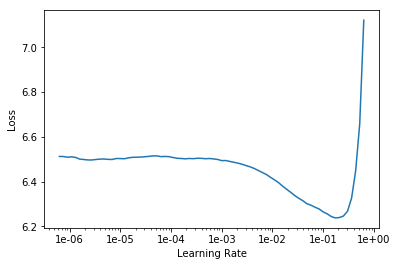

In [24]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4, max_lr=4e-02)

epoch,train_loss,valid_loss,error_rate
1,4.597380,4.690246,0.917942
2,4.527675,4.381288,0.883211


## Archive

In [ ]:
def stroke2img(raw_strokes, size=64):
    img = Image.new()